## Using Grover search

1. [Grover Search ](#grover-search)<br/> 
    1.1 [Grover algorithm](#grover-algorithm)<br/>
    1.2 [Quantum Oracle function](#quantum-oracle)<br/>
    1.3 [Grover Operator](#grover-operator)<br>       
2. [Throwing a party while avoiding the drama](#example-party)<br/>
3. [Solving a simple 2x2 Sudoku problem](#sudoku)<br/>
4. [Card finding problem](#example-card-finding)<br/>

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import MCMT, ZGate, StatePreparation, GroverOperator
from qiskit_aer import Aer
from qiskit.visualization import plot_distribution
import numpy as np
from qiskit.circuit.library.phase_oracle import PhaseOracle
from qiskit.circuit.library import GroverOperator

In [ ]:
# required for PhaseOracle
!pip install tweedledum

# Grover search <a id='grover-search'></a>

Imagine you search a phone number in the book containing onemillion entries.
- Its not a problem, you just look at the name as they are in order.
- But what about doing the inverse ? You have a phone number and looking for the name.

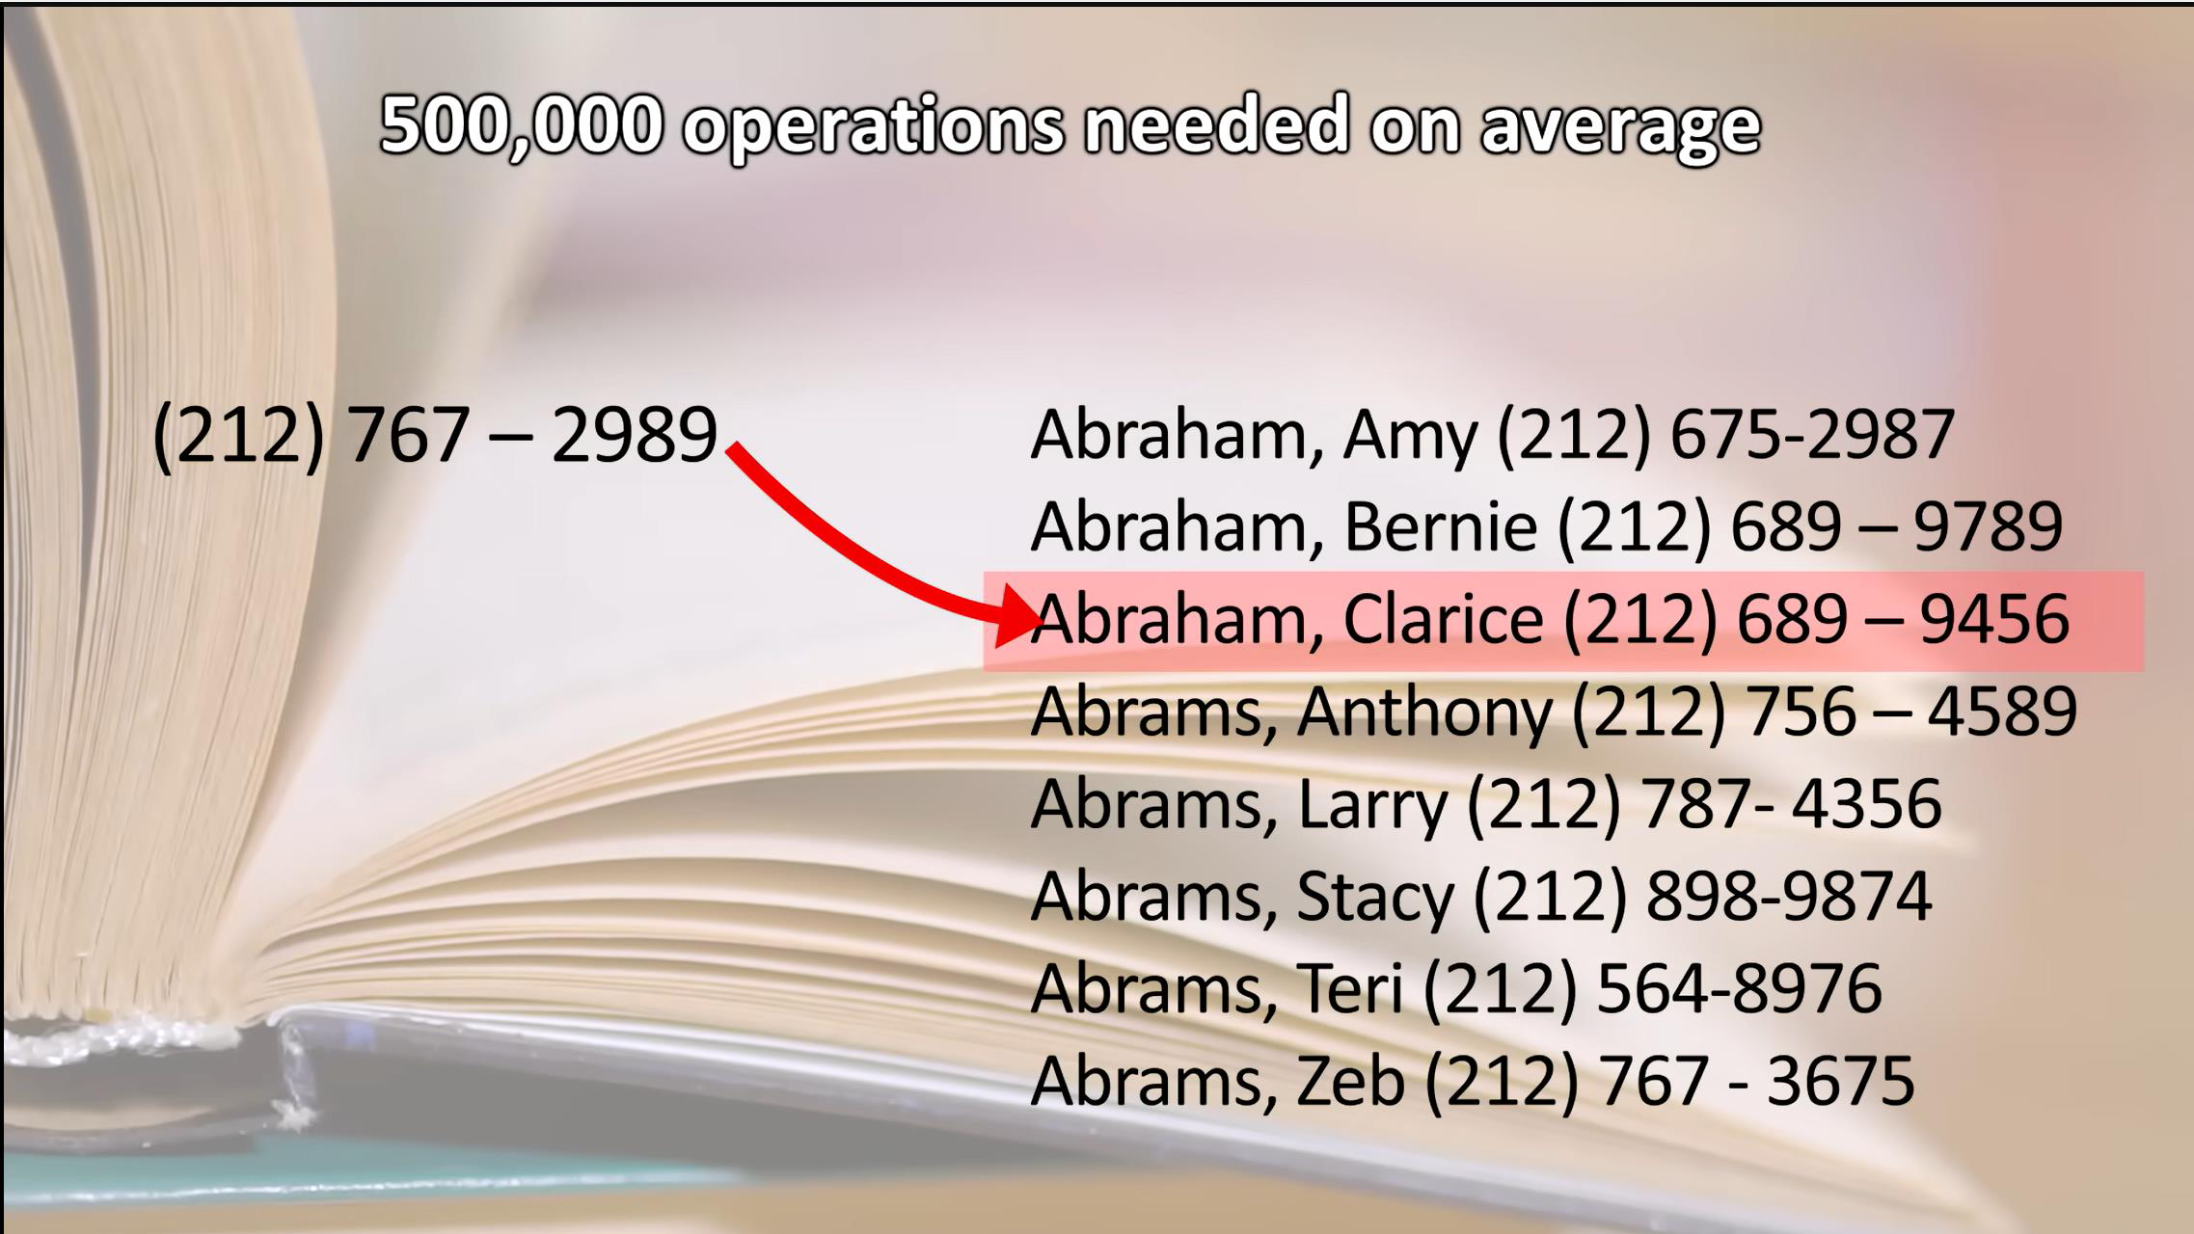

Quantum Computer can find a name in 1000 operations instead on 500000(avg) for a classical computer

From source https://arxiv.org/abs/1804.03719

Grover's algorithm can be used to 
- Find "$with$ $a$ $good$ $probability$" a specific $item$ within a randomly ordered database of $N$ items using $O(√N)$ operations. Quadratic speedup over classical algorithm.
- Solve decision problems and boolean satisfiability problems with constraints like sudoku(Is the formula true ? ) $(Satisfiability)$ 
- For a classical computer, this takes linear $O(N)$ time, because to prove that it doesn’t you have to look at all $N$ values, and if it does once then on average you need to look at $N/2$ values to find it. So the fact that the list is unsorted and unstructured is important.
    - Note that if the list is sorted it would only take $O(log(n))$ time, 
    - And if the values were in a hash table only constant $O(1)$

Grover’s algorithm allows you to tell whether a particular value exists in $O(√N)$ steps. 
This quadratic speedup comes in the $number$ of $oracle$ $calls$, where one oracle call gives us only the information whether the questioned-about element is the target one or not


# *Grover Algorithm* <a id='grover-algorithm'></a>
The Grover algorithm is made of a $state$ $preparation$, a $quantum$ $Oracle$ and a $grover$ $Operator$.

 1. Begin with uniform superposed state (i.e. Hadamard gate applied to |00000>). All possible $x$ values have the same amplitudes
 
 2. Apply the $Oracle$ (flip amplitude of state that matches search criterion). The query with $U_f$ , a unitary transformation that flips the amplitude of the marked item: $U_f |x⟩ = (-1)^{f(x)} |x⟩$.
 
 3. Reverse the sign of all states except $|0\rangle$ which represents the mean. Next we apply a unitary matrix $​D​$ (3), which has the effect of flipping all $​N​$ amplitudes about the mean amplitude.
 
 4. Go to step $2$

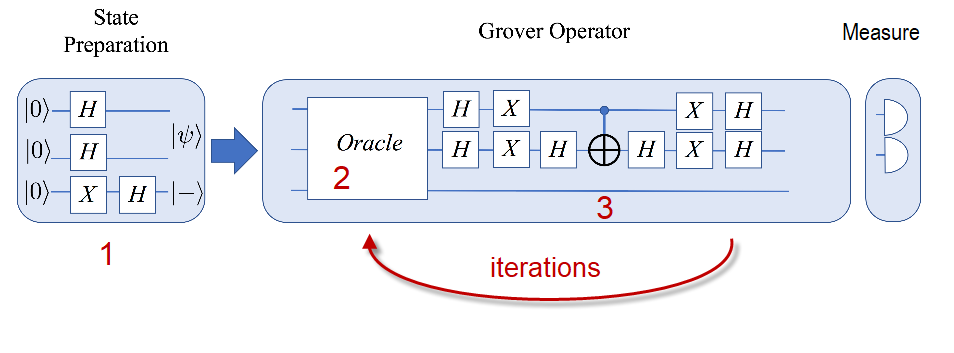

# State Preparation

The first step of Grover's algorithm is the initial state preparation. The search space is all possible values we need to search through to find the answer we want. The 'database' is comprised of all the possible computational basis states our qubits can be in. For example, if we have 3 qubits, our list is the states (i.e the states |0⟩ -> |7⟩). So, in this case the size of our search space will be N = 2^3

In some cases, if we know the range within the search space where the answer is guaranteed to be, we can eliminate the redundant basis out of our search space to speed up the algorithm and decrease the size of the circuit. Generally speaking, we can prepare our state using any symmetric states, such as GHZ-states, W-states...

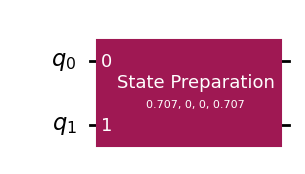

In [3]:
# Example of creating a bell state with an arbitrary state preparation(not efficient but good for learning purposes)
state_prep = QuantumCircuit(2)
instruction = StatePreparation([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)])
state_prep.append(instruction, [0,1])
state_prep.draw('mpl')

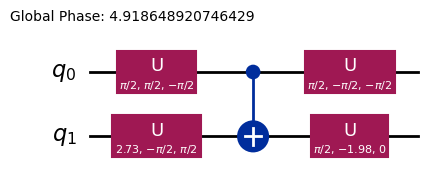

In [4]:
# if we transpile the circuit looks like
state_prep = transpile(state_prep, basis_gates=['u', 'cx'], optimization_level=3)
state_prep.draw('mpl')

# *Quantum Oracle*<a id='quantum-oracle'></a>

The $"quantum$ $oracle"$  is the most important part of Grover algorithm and it is a boolean function that helps identify the desired item in an unsorted database. Think of the oracle as a “black box” function $f$ that provides essential information, enabling the algorithm to efficiently locate the target item. 

- The function $f(x)$ is defined by

    - $f(x)\ = \ 1 ,  \ \  if  \ x \ = \ x^*  \ \  \ \rightarrow  \ \  so \ x \ IS \ the \ solution \ to \ the \ search \ problem $
    - $ f(x)\ = \ 0 ,  \ \  if  \ x \ \neq \ x^* \ \  \ \rightarrow  \ \  so \ x \ IS \ NOT \ the \ solution \ to \ the \ search \ problem $      
     ( $x^*$ being the item sought )

### *Quantum Phase Oracle* 
In Grover algorithm, the items marked by the $"quantum$ $oracle"$ are given a negative sign. It's called Phase Oracle

In other words, the Phase oracle is a unitary operator $U$ satisfying 
    $$\ \boxed{U|x〉 = \begin{cases}-|x⟩ & \text{if $x$ is marked} \\|x⟩  & \text{if $x$ is not marked}\end{cases}}$$
    
        

### *Quantum Oracle action example with 3 qubits*

<b>1. &nbsp; &nbsp;</b>   Apply Hadamard gates to $3$ qubits initialised to $|000⟩$ to create a uniform superposition. We get the $|\psi⟩$ state: $$|ψ⟩= H^{⊗n}|0⟩^{⊗n} = \frac{1}{\sqrt{2{^n}}}\sum_{x=0}^{2^n-1}|x⟩$$  With $n$=$3$ we end with : $$|ψ⟩=\frac{{1 }}{\sqrt{8}}(|000⟩+|001⟩+|010⟩+|011⟩+|100⟩+|101⟩+|110⟩+|111⟩)$$

   ($3$ $qubits \rightarrow N$ = $2^n$ = $8$) to obtain equal amplitudes associated with each state of $\frac{1}{\sqrt{N}}$ = $\frac{1}{\sqrt{8}}$ = $\frac{1}{2\sqrt{2}}$, and thus also equal probability of being in any of the $8$ possible states.
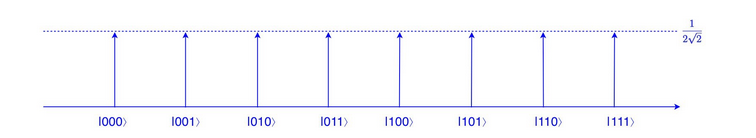


<b>2. &nbsp; &nbsp;</b>  Mark states $|011⟩$ using a $phase$ oracle. We get :
$$|ψ⟩=\frac{{1 }}{\sqrt{8}}(|000⟩+|001⟩+|010⟩-|011⟩+|100⟩+|101⟩+|110⟩+|111⟩)$$

- In the example below, $f(011)$ = $1$ after applying the $Oracle$ $function$, The oracle query will negate the amplitude of the state (in this case $|011⟩$), 

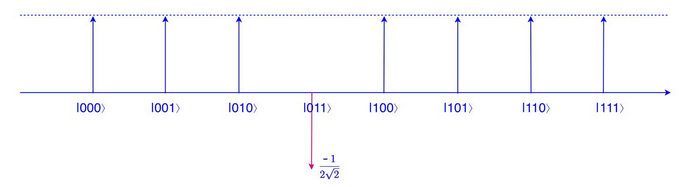

## How to construct an oracle
Implementing the Quantum Oracle(boolean oracle) can be reduced to constructing a quantum circuit that flips an ancillary qubit (called the oracle qubit) if the items are marked. We apply a multi controlled gate X with target the ancilla qubit and controls the qubits of our database.
For the phase oracle, a multi controlled gate Z is applied on the last qubit as target instead, no need to use an ancilla qubit. 
Note that, if the qubit contains 0 we apply a X gate.

We will only use the PhaseOracle

- The table below gives an example of 3(4) qubits (Boolean and phase) Oracles circuits to provide a single solution with Grover (source : https://arxiv.org/pdf/1703.10535.pdf) 

 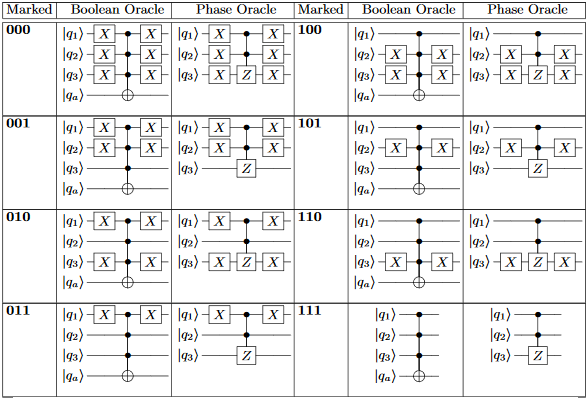
 
    

In [5]:
# function for creating a phase oracle, you can reuse it for the below exercises
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        try:
            # where the target bit-string has a '0' entry
            qc.x(zero_inds)
            qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
            qc.x(zero_inds)
        # in case the marked state contains only 1
        except:
            qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
    return qc

In [6]:
# Phase oracle of the  state |001⟩
marked_states = ["001"]

oracle = grover_oracle(marked_states)

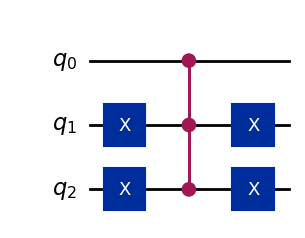

In [7]:
#draw the oracle
oracle.draw('mpl')

### construct an oracle using logical expressions

Qiskit also provides the PhaseOracle object to construct Oracle. It accepts a logical expressions as input.

In [8]:
from qiskit.circuit.library.phase_oracle import PhaseOracle
expression='( x0 & ~x1 & ~x2 )'
oracle = PhaseOracle(expression)

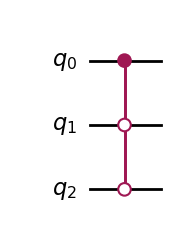

In [9]:
# draw the Oracle
oracle.draw('mpl')

Note that if you decompose the circuit it is equivalent to the oracle of the marked state |10⟩

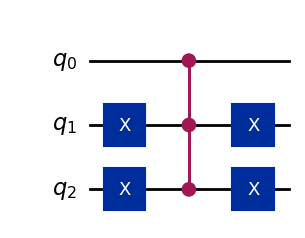

In [10]:
oracle.decompose(reps=1).draw('mpl')

### Exercise: 
create an oracle that flip the states |000⟩ and |110⟩ and run the circuit after applying hadamard gates

In [12]:
# Create a QuantumCircuit with hadamards on all the 2 qubits
circuit = QuantumCircuit(3)
circuit.h([0,1,2])

# create another circuit for the oracle that recognizes |000⟩ and |110⟩ 

oracle = grover_oracle()

# append the oracle on the QuantumCircuit

circuit.append(oracle, [0,1,2])

# transpile and execute the circuit on the statevector simulator

simulator = Aer.get_backend('statevector_simulator')
circuit = transpile(circuit, simulator)
result = simulator.run(circuit).result()

# print the statevector

print('statevector: ', result.get_statevector())
circuit.draw('mpl')

Traceback (most recent call last):
  Cell In[12], line 7
    oracle = grover_oracle()
TypeError: grover_oracle() missing 1 required positional argument: 'marked_states'

Use %tb to get the full traceback.


#  *The Grover Operator or  "Diffusion  Transform  Operator"*  <a id='grover-operator'></a>

               
 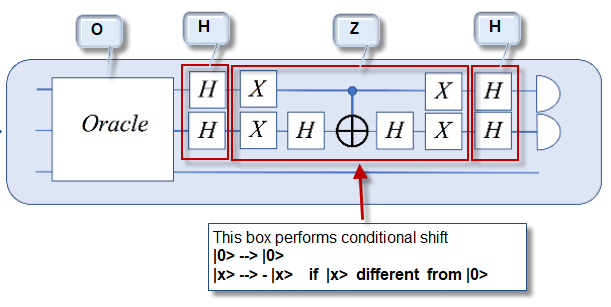

    

So after the first Grover iteration we have the following: 

- After having applied the $Oracle$, (the amplitude changed to negative for the searched $item$)  
    - The average amplitude decreased. 
    
- Applying the Grover Operator will then flip every amplitude around the average
    - Thus increasing the amplitude of the searched $item$ and lowering the others. 
    

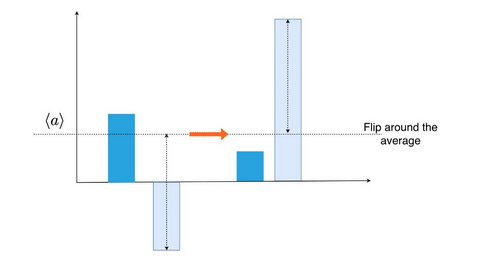
         
  

### Example of a Grover Operator acting on 3 qubits

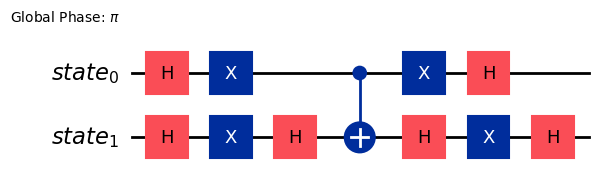

In [13]:
grover_op = GroverOperator(oracle = QuantumCircuit(2))
grover_op.decompose().draw('mpl')

## Final Grover circuit

The final step of grover is to run the previous steps. The optimal number of iterations that we'll call $m$ is directly linked to the number of Qubits of the circuit, and is 
$$m = \frac{\pi}{4}\sqrt{2^{N}}$$  with $N$ beeing the number of Qubits

If we have several items to search, we divide this value by the number of marked states

Below an example of grover search algorithm, we want to find the state |011⟩ on a dataset of $N$ = $2^n$ = $8$ states

optimal number of iterations:  2


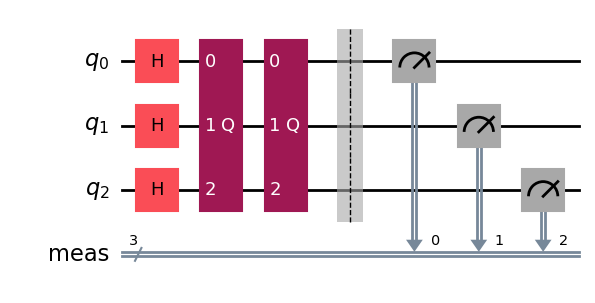

In [17]:
import math
marked_states = ['011']
num_qubits = 3
optimal_num_iterations = math.floor(
    math.pi / 4 * math.sqrt(2**num_qubits / len(marked_states))
)
print('optimal number of iterations: ', optimal_num_iterations)

grover_circuit= QuantumCircuit(num_qubits)

# Apply hadamard gates
grover_circuit.h(range(num_qubits))
oracle = grover_oracle(marked_states)

# instanciate grover operator
grover_op = GroverOperator(oracle = oracle)
grover_circuit.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
grover_circuit.measure_all()

grover_circuit.decompose(gates_to_decompose='H').draw('mpl')

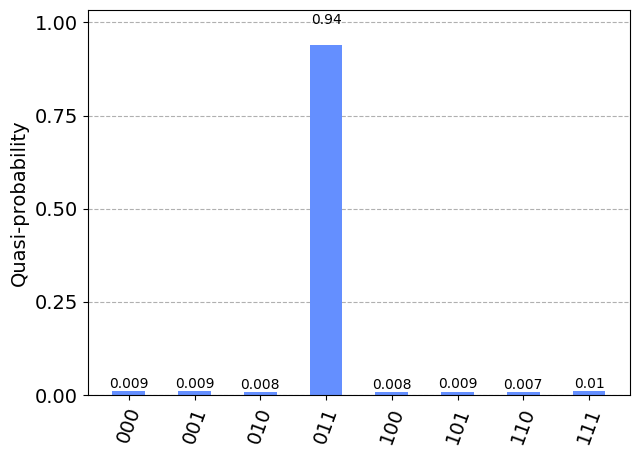

In [18]:
# use aer qasm simulator
sim_qasm = Aer.get_backend('qasm_simulator')
# transpile the circuit 
grover_circuit = transpile(grover_circuit, sim_qasm)

result = sim_qasm.run(grover_circuit, shots=int(1e4)).result()

# plot the distribution probability 
plot_distribution(result.get_counts())

#### Your turn

Find the states |0011〉 and |1100〉using grover algorithm on 4 qubits

In [19]:
import math
marked_states = 
num_qubits = 
optimal_num_iterations = math.floor(
    math.pi / 4 * math.sqrt(2**num_qubits / len(marked_states))
)
print('optimal number of iterations: ', optimal_num_iterations)

grover_circuit= QuantumCircuit(num_qubits)

# Apply hadamard gates
grover_circuit.h(range(num_qubits))
oracle = grover_oracle(marked_states)

# instanciate grover operator
grover_op = GroverOperator(oracle = oracle)
grover_circuit.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
grover_circuit.measure_all()

grover_circuit.decompose().draw('mpl')

Traceback (most recent call last):
  File /opt/conda/lib/python3.10/site-packages/IPython/core/compilerop.py:86 in ast_parse
    return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)
  Cell In[19], line 2
    marked_states =
                    ^
SyntaxError: invalid syntax

Use %tb to get the full traceback.


In [ ]:
# use aer qasm simulator
sim_qasm = Aer.get_backend('qasm_simulator')
# transpile the circuit 
grover_circuit = transpile(grover_circuit, sim_qasm)

result = sim_qasm.run(grover_circuit, shots=int(1e4)).result()

# plot the distribution probability 
plot_distribution(result.get_counts())

# Examples using Grover

## *Throwing a party while avoiding the drama* <a id='example-party'></a>

Imagine you are inviting some friends to a party, some who are couples, and some who are not on speaking terms. Specifically, **Alice** and **Bob** are in a relationship, as are **Carol** and **David**. However, **Alice** and **David** had a bad breakup a while ago and haven't been civil with each other since. And **Bob** doesn't want to meet **Carol** and **David** if he is alone. Armed with a quantum computer, how can you leverage Grover search algorithm to identify friendly combinations of people to invite?

Fortunately, Grover search may be used for [boolean satisfiability problems](https://en.wikipedia.org/wiki/Boolean_satisfiability_problem), and the constraints for our party planning problem may be formulated with a boolean expression.

Define the boolean or logical expression(oracle) of the problem and use Grover search to find out compatible combinations of people to invite.
> Note: We'll represent `and` with `&`, `or` with `|`, `not` with `~` , `xor` with`^` in our expression.

An example of logical expression: `((A and B) or (C and D)) or not (B and D)`

In [20]:
from qiskit.circuit.library.phase_oracle import PhaseOracle

# create the logical expression that model our problem
log_expr = ''
oracle = PhaseOracle(log_expr)
oracle.draw(output='mpl')

Traceback (most recent call last):
  Cell In[20], line 5
    oracle = PhaseOracle(log_expr)
  File /opt/conda/lib/python3.10/site-packages/qiskit/utils/classtools.py:112 in out
    retval = method(*args, **kwargs)
  File /opt/conda/lib/python3.10/site-packages/qiskit/circuit/library/phase_oracle.py:70 in __init__
    expression = BooleanExpression(expression, var_order=var_order)
  File /opt/conda/lib/python3.10/site-packages/qiskit/utils/classtools.py:112 in out
    retval = method(*args, **kwargs)
  File /opt/conda/lib/python3.10/site-packages/qiskit/circuit/classicalfunction/boolean_expression.py:39 in __init__
    self._tweedledum_bool_expression = BoolFunction.from_expression(
  File /opt/conda/lib/python3.10/site-packages/tweedledum/bool_function_compiler/bool_function.py:148 in from_expression
    parsed_expression = ExpressionParser(expression, var_order)
  File /opt/conda/lib/python3.10/site-packages/tweedledum/bool_function_compiler/expression_parser.py:14 in __init__
    sup

In [ ]:
import math
num_qubits = oracle.num_qubits

grover_circuit= QuantumCircuit(num_qubits)
grover_circuit.h(range(num_qubits))
grover_op = GroverOperator(oracle = oracle)
grover_circuit.compose(grover_op.power(1), inplace=True)
# Measure all qubits
grover_circuit.measure_all()

grover_circuit.decompose(reps=2).draw('mpl')

Now we'll run the algorithm on a simulator, printing the result that occurred most often. This result is expressed as the numeric representations of our four friends; a minus sign indicating which ones Grover advised against inviting in that particular result.

In [ ]:
# Run the algorithm on a simulator, printing the most frequently occurring result
sim_qasm = Aer.get_backend('qasm_simulator')
grover_circuit = transpile(grover_circuit, sim_qasm)
result = sim_qasm.run(grover_circuit, shots=int(1e4)).result()

Finally, we'll plot the results. Each basis state represents our four friends, with the least significant bit representing Alice. If a bit is 1, then the advice is to invite the person that the bit represents. If the bit is 0, then Grover advises not to send an invitation.

In [ ]:
plot_distribution(result.get_counts())

## *Solving a simple 2x2 Sudoku problem* ## <a id='sudoku'></a>

Our problem is a 2×2 binary sudoku, which in our case has two simple rules:

    No column may contain the same value twice
    No row may contain the same value twice

If we assign each square in our sudoku to a variable like so:

2×2 binary sudoku, with each square allocated to a different variable and can be 0 or 1

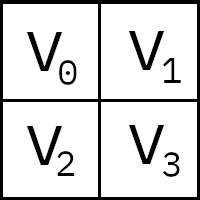

To solve the problem, we need to check down both columns and across both rows, there are 4 conditions we need to check:

<br> v0 ≠ v1   # check along top row</br>
<br> v2 ≠ v3   # check along bottom row</br>
<br> v0 ≠ v2   # check down left column</br>
<br> v1 ≠ v3   # check down right column</br>

#### Implement grover algorithm to find the solutions

In [ ]:
# create the logical expression
log_expr = ''

# create the Oracle of the logical expression
oracle = PhaseOracle(log_expr)

# draw the oracle
oracle.draw(output='mpl')

In [ ]:
# Create a quantumCircuit and call it grover_circuit with the same number of qubits of the Oracle
import math
num_qubits = oracle.num_qubits
grover_circuit= QuantumCircuit(num_qubits)

# Apply hadamard gates on all qubits
grover_circuit.h(range(num_qubits))

# Define the GroverOperator
grover_op = GroverOperator(oracle = oracle)

# Compose the Grover circuit with the grover operator
grover_circuit.compose(grover_op.power(1), inplace=True)
# Measure all qubits
grover_circuit.measure_all()

grover_circuit.decompose(reps=2).draw('mpl')

In [ ]:
# Run the algorithm on a simulator, printing the most frequently occurring result
sim_qasm = Aer.get_backend('qasm_simulator')
grover_circuit = transpile(grover_circuit, sim_qasm)
result = sim_qasm.run(grover_circuit, shots=int(1e4)).result()

In [ ]:
# plot the distribution of the results
plot_distribution(result.get_counts())


## Card finding problem <a id='example-card-finding'></a>

As an example, we want to find the card which satisfy a serie of conditions which worth 0 or 1.

We have a set of 32 cards, whose colors are $spade$, $club$, $diamond$ and $heart$. 
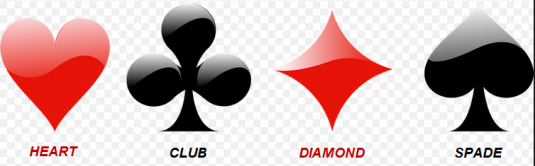


As in the $belote$ game, these cards are $7$, $8$, $9$, $10$, $J$, $Q$, $K$, $A$. 
Since we want to find a way to describe these cards with (simple) logical operators, we decide of additionnal properties to caracterize them. 
* First, the parity of the card, starting with the 7 (odd) up to the ace (even).
* Second, the value of the card if it was a trump suit card (which, in belote, can be separated between low values (7, 8, Q, K) and high values (10, A, 9, J)).
* It can seem far-stretched (because it is), but this facilitates the mapping, making explanations clearer. 

We thus have a way to describe any card with boolean caracteristics:
* $x_0$: is the card black ?
* $x_1$: is it either a club or a heart ? (depending on $x_0$)
* $x_2$: is its symbol a letter ? (ie J, Q, K, A)
* $x_3$: is its value high ? (ie 10, A, 9, J)
* $x_4$: is it odd ?

##### What is the logical expression that encodes the Queen of Hearts?
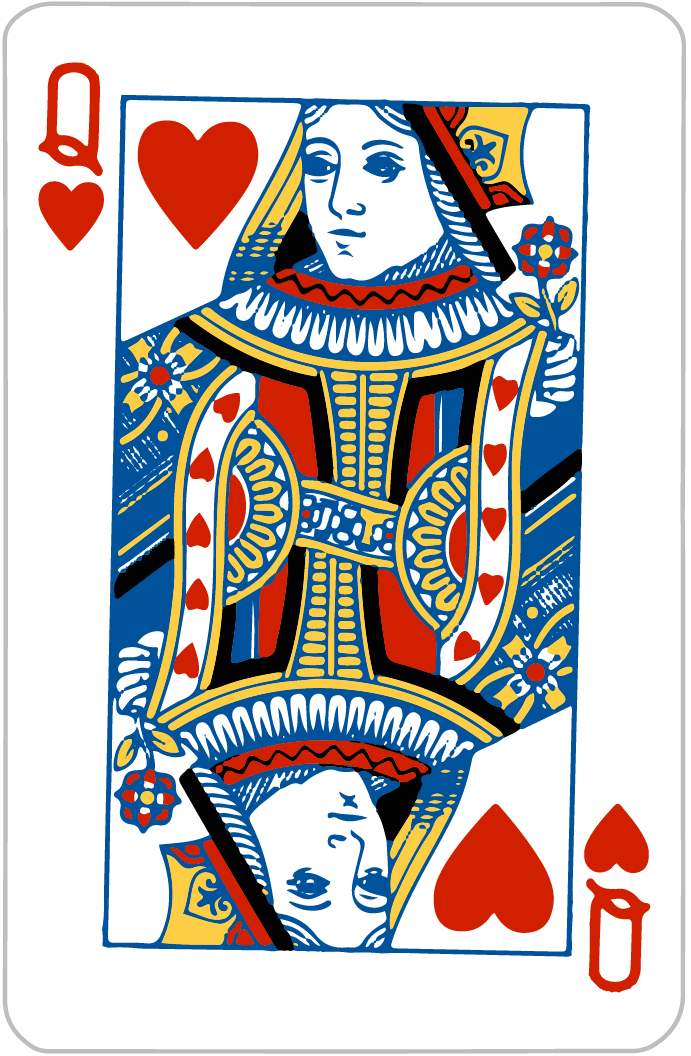

In [ ]:
# we look for the queen of heart 
expression=''

In [23]:
# instantiate the phase oracle
oracle=PhaseOracle(expression)

In [ ]:
# Use the method .circuit.draw() to the Oracle to draw the associated circuit
style = {'backgroundcolor': 'lightcyan'}
oracle.draw(output='mpl', style=style)

Now invoke the Grover algorithm using the Oracle you created previously

In [ ]:
num_qubits = oracle.num_qubits
grover_circuit= QuantumCircuit(num_qubits)

# Apply hadamard gates on all qubits
grover_circuit.h(range(num_qubits))

# Define the GroverOperator
grover_op = GroverOperator(oracle = oracle)

# Compose the Grover circuit with the grover operator
grover_circuit.compose(grover_op.power(2), inplace=True)
# Measure all qubits
grover_circuit.measure_all()

grover_circuit.decompose( reps=2).draw('mpl')

In [ ]:
# Run the algorithm on a simulator, printing the most frequently occurring result
sim_qasm = Aer.get_backend('qasm_simulator')
grover_circuit = transpile(grover_circuit, sim_qasm)
result = sim_qasm.run(grover_circuit, shots=int(1e4)).result()

In [ ]:
# plot the distribution of the results
plot_distribution(result.get_counts())

In [ ]:
# map your bitstring to a card
def convert_to_card(val):
    color = int(val[3:], 2)
    sign = int(val[::-1][2:], 2)

    colors = ["clubs", "spades", "hearts", "diamonds"]
    signs = ["8", "7", "10", "9", "Queen", "King", "Ace", "Jack"]

    return signs[sign] + " of " + colors[color]

In [ ]:
# print the most frequent result and verify if your bitstring is the queen of hearts
print(result.get_counts().most_frequent())
print(convert_to_card(result.get_counts().most_frequent()))